In [12]:
# Imports
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import numpy as np
import string
import timeit
import time
import re
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from ordered_set import OrderedSet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [13]:
# Functions from hand on 1
def get_and_clean_data():
    data = pd.read_csv('../Week 1/resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' '*len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

def simple_tokenize(data):
    cleaned_description = data.apply(lambda s: [x.strip() for x in s.split()])
    return cleaned_description

def parse_job_description():
    cleaned_description = get_and_clean_data()
    cleaned_description = simple_tokenize(cleaned_description)
    return cleaned_description

---
- Page 74, 75 (Hand_out 2) : Activity — performance benchmark 
    - `Set operations vs list operation in stemming`

In [14]:
# (Given)
def set_operation(sample_size):
    cleaned_description = get_and_clean_data()[:sample_size]

    #replace non alphabets with spaces, and collapse spaces
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

    #tokenize
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    #remove stop words
    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    #create stem caches
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)

    #stem
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

    return stemmed_description

def list_operation(sample_size):
    cleaned_description = get_and_clean_data()[:sample_size]

    #replace non alphabets with spaces, and collapse spaces
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

    #tokenize
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    #remove stop words
    stop_dict = list(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: [word for word in s if word not in stop_dict])
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    #create stem caches
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)

    #stem
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

    return stemmed_description


In [15]:
# Benchmark
t_set = []
t_list = []
for i in range(100, 401, 100):
    t_set.append(timeit.timeit(lambda: set_operation(i), number=1))
    t_list.append(timeit.timeit(lambda: list_operation(i), number=1))

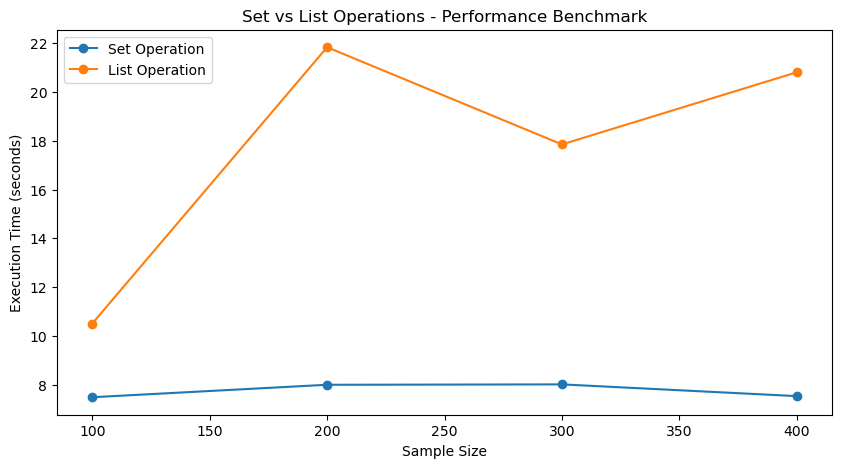

In [16]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(100, 401, 100), t_set, label='Set Operation', marker='o')
plt.plot(range(100, 401, 100), t_list, label='List Operation', marker='o')

plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Set vs List Operations - Performance Benchmark')
plt.legend()

plt.show()

---
- Page 76 `handout 2` : Multiprocessing

In [17]:
def better_set_operation(cleaned_description):
    #replace non alphabets with spaces, and collapse spaces
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

    #tokenize
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    #remove stop words
    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    #create stem caches
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)

    #stem
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

    return stemmed_description

In [18]:
cleaned_description = get_and_clean_data()

core_exp = {}

for c in [1,2,4,8,12]:
    # 1, 2, 4, 8, ...
    start = time.time()
    print(f"Running: {c} core(s)")
    
    parsed_description_split = np.array_split(cleaned_description, c)
    with multiprocessing.pool.ThreadPool(c) as pool:
        pool.map(better_set_operation, parsed_description_split)
    
    end = time.time()
    core_exp[c] = end - start


Running: 1 core(s)


c:\Users\Admin\anaconda3\envs\SE-IR\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Running: 2 core(s)
Running: 4 core(s)
Running: 8 core(s)
Running: 12 core(s)


In [19]:
core_exp

{1: 27.136950254440308,
 2: 26.346041917800903,
 4: 21.491621494293213,
 8: 21.90003252029419,
 12: 21.456997394561768}

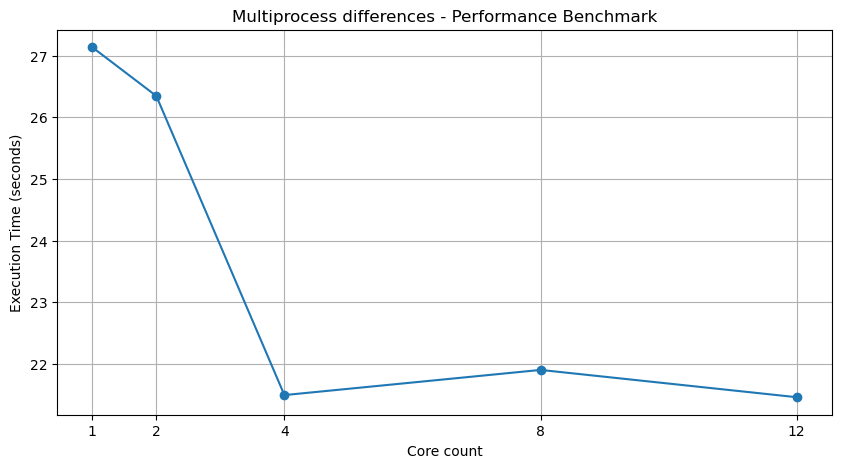

In [20]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(list(core_exp.keys()), list(core_exp.values()), marker='o')

plt.xlabel('Core count')
plt.ylabel('Execution Time (seconds)')
plt.title('Multiprocess differences - Performance Benchmark')
plt.xticks(list(core_exp.keys()))  # Show all core counts on the x-axis
plt.grid(True)
plt.show()

---
- page 78 `handout 2` : speedup time

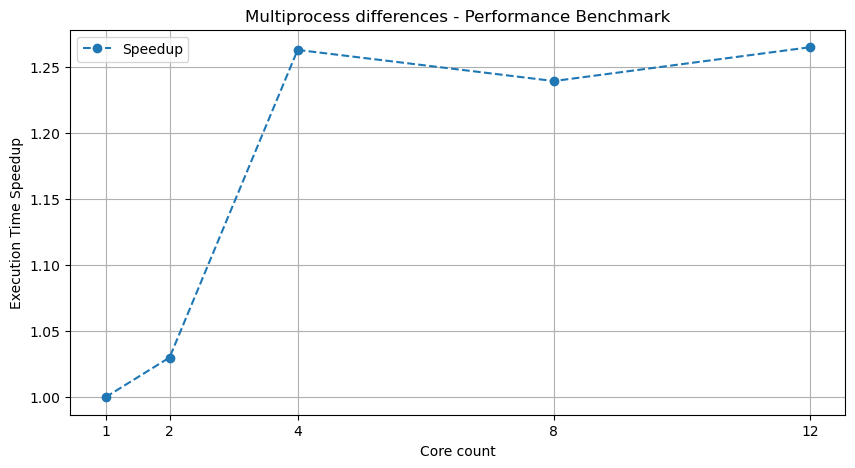

In [31]:
# Calculate Speedup for each core count
speedup = {c: core_exp[1] / time for c, time in core_exp.items()}

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(list(speedup.keys()), list(speedup.values()), marker='o', linestyle='--', label='Speedup')

plt.xlabel('Core count')
plt.ylabel('Execution Time Speedup')
plt.title('Multiprocess differences - Performance Benchmark')
plt.xticks(list(core_exp.keys()))  # Show all core counts on the x-axis
plt.legend()
plt.grid(True)
plt.show()

---
- Page 11 - 12 of `Handout #3` : Converting into a full scikit-learn process

In [27]:
# old codes
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
# Page 11 : 
def create_stem_cache(cleaned_description):
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)
    return stem_cache

def create_custom_preprocessor(stop_dict, stem_cache):
    def custom_preprocessor(s):
        ps = PorterStemmer()
        s = re.sub(r'[^A-Za-z]', ' ', s)
        s = re.sub(r'\s+', ' ', s)
        s = word_tokenize(s)
        s = list(OrderedSet(s) - stop_dict)
        s = [word for word in s if len(word)>2]
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s]
        s = ' '.join(s)
        return s
    return custom_preprocessor

In [26]:
# Page 12 :
def sk_vectorize(texts, cleaned_description, stop_dict, stem_cache):
    my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
    vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
    vectorizer.fit(cleaned_description)
    query = vectorizer.transform(texts)
    print(query)
    print(vectorizer.inverse_transform(query))

cleaned_description = get_and_clean_data()
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words('English'))
sk_vectorize(['python is simpler than java'], cleaned_description, stop_dict, stem_cache)

  (0, 13947)	1
  (0, 21383)	1
  (0, 24234)	1
[array(['java', 'python', 'simpler'], dtype='<U124')]
